In [192]:
import time

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, HuberRegressor, Lasso, LinearRegression, OrthogonalMatchingPursuit, Ridge, RANSACRegressor, TheilSenRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_decomposition import PLSRegression

from warnings import filterwarnings
filterwarnings('ignore')

In [193]:
df_train_copy = pd.read_csv('../Datasets/preprocessed_datasets/final_selected_features_data_copy.csv')
df_test = pd.read_csv('../Datasets/preprocessed_datasets/final_selected_features_df_test.csv')

In [194]:
features = [col for col in df_train_copy.columns if col != "SalePrice"]
print(features)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'GarageFinish', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'CentralAir_Y', 'YearRemodAdd_Age', 'YearBuilt_Age']


In [195]:
# Define hyperparameter grids for each model
param_grids = {
    # "GradientBoostingRegressor": {
    #     'n_estimators': [50, 1000, 3000, 5000],
    #     'learning_rate': [0.05, 0.1, 0.15],
    #     'max_depth': [3, 5, 8],
    #     'loss': ['huber', 'quantile'],
    #     'min_samples_split': [5, 10, 15],
    #     'min_samples_leaf': [5, 10, 15],
    #     'max_features': [None, 'sqrt', 'log2']
    # },
    "GradientBoostingRegressor": {
        'learning_rate': [0.05], 
        'loss': ['huber'], 
        'max_depth': [8], 
        'max_features': ['log2'], 
        'min_samples_leaf': [15], 
        'min_samples_split': [10], 
        'n_estimators': [2000]
    },
    # "AdaBoostRegressor": {
    #     'n_estimators': [50, 1000, 3000, 5000],
    #     'learning_rate': [0.05, 0.1, 0.15],
    #     'loss': ['linear', 'square', 'exponential'],
    # },
    # "RandomForestRegressor": {
    #     'n_estimators': [50, 1000, 3000, 5000],
    #     'max_depth': [3, 5, 8],
    #     'min_samples_split': [5, 10, 15],
    #     'min_samples_leaf': [5, 10, 15],
    #     'bootstrap': [True, False]
    # },
    # "BaggingRegressor": {
    #     'n_estimators': [50, 100, 150, 200],
    #     'max_samples': [0.5, 0.7, 0.9],
    #     'max_features': [0.5, 0.7, 0.9],
    #     'bootstrap': [True, False],
    #     'bootstrap_features': [True, False]
    # },
    # "XGBRegressor": {
    #     'n_estimators': [50, 100, 150, 200, 300, 400],
    #     'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    #     'max_depth': [3, 5, 8]
    # },
    # "LGBMRegressor": {
    #     'n_estimators': [50, 100, 150, 200, 300, 400],
    #     'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    #     'max_depth': [3, 5, 8],
    #     'verbose': [0]
    # },
    # "CatBoostRegressor": {
    #     'iterations': [50, 100, 150, 200, 300, 400],
    #     'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    #     'depth': [3, 5, 8],
    #     'verbose': [False]
    # },
    # "ElasticNet": {
    #     'alpha': [0.01, 0.1, 1, 10, 100],
    #     'l1_ratio': [0.1, 0.5, 0.9]
    # },
    # "HuberRegressor": {
    #     'alpha': [0.01, 0.1, 1, 10, 100]
    # },
    # "Lasso": {
    #     'alpha': [0.01, 0.1, 1, 10, 100]
    # },
    # "LinearRegression": {
    #     # No hyperparameters to tune for linear regression
    # },
    # "OrthogonalMatchingPursuit": {
    #     'n_nonzero_coefs': [None, 5, 10, 20, 30]
    # },
    # "Ridge": {
    #     'alpha': [0.01, 0.1, 1, 10, 100]
    # },
    # "RANSACRegressor": {
    #     'min_samples': [0.1, 0.5, 0.9],
    #     'residual_threshold': [1.0, 2.0, 3.0]
    # },
    # "TheilSenRegressor": {
    #     'max_subpopulation': [1e3, 1e4, 1e5]
    # },
    # "GaussianProcessRegressor": {
    #     'alpha': [1e-2, 1e-3, 1e-10]
    # },
    # "KernelRidge": {
    #     'alpha': [0.01, 0.1, 1, 10, 100],
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    # },
    # "KNeighborsRegressor": {
    #     'n_neighbors': [3, 5, 7, 9, 11],
    #     'weights': ['uniform', 'distance']
    # },
    # "SVR": {
    #     'C': [0.1, 1, 10, 100],
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    # },
    # "DecisionTreeRegressor": {
    #     'max_depth': [3, 5, 8, None],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # },
    # "ExtraTreeRegressor": {
    #     'max_depth': [3, 5, 8, None],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # },
    # "MLPRegressor": {
    #     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    #     'activation': ['relu', 'tanh'],
    #     'solver': ['adam', 'sgd'],
    #     'learning_rate': ['constant', 'invscaling', 'adaptive']
    # },
    # "make_pipeline(PolynomialFeatures(degree=2), LinearRegression)": {
    #     # No hyperparameters to tune for this pipeline
    # },
    # "PLSRegression": {
    #     'n_components': [2, 4, 6, 8, 10]
    # }
}

In [196]:
# Splitting data for cross-validation using KFold splitting
kf = KFold(n_splits=10, shuffle=True, random_state=619)

In [197]:
# Create a table to store results of GridSearchCV
results_columns = ['Model', 'Best Params', 'Best Score', 'Best Model', 'Refit Time']
results_df = pd.DataFrame(columns=results_columns)

In [198]:
# Perform hyperparameter tuning for each model and store results row-wise
total_start_time = time.time()

index = 0

for model_name, param_grid in param_grids.items():

    print(f"Fitting model: {model_name}...")

    # Instantiate model from string name
    if model_name == "make_pipeline(PolynomialFeatures(degree=2), LinearRegression)":
        model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    else:
        model = eval(model_name)()

    start_time = time.time()
    search = GridSearchCV(model, param_grid, scoring=make_scorer(mean_squared_error, squared=False), cv=kf, verbose=1, n_jobs=-1)
    search.fit(df_train_copy[features], df_train_copy["SalePrice"])
    end_time = time.time()
    
    # Store results
    results_df.loc[index, 'Model'] = model.__class__.__name__
    results_df.loc[index, 'Best Params'] = str(search.best_params_)
    results_df.loc[index, 'Best Model'] = str(search.best_estimator_)
    results_df.loc[index, 'Best Score'] = search.best_score_
    results_df.loc[index, 'Refit Time'] = search.refit_time_
    results_df.loc[index, 'Total Model Grid Search Tuning Time'] = end_time - start_time

    index += 1

total_end_time = time.time()

total_run_time = total_end_time - total_start_time
print('Total time taken by Hyperparameter tuning is {:.2f} minutes.'.format(total_run_time / 60))

# Print the model results in ascending order to get the best performing model
results_df.sort_values('Best Score', ascending=True, inplace=True)
display(results_df)

Fitting model: GradientBoostingRegressor...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Total time taken by Hyperparameter tuning is 1.00 minutes.


,Model,Best Params,Best Score,Best Model,Refit Time,Total Model Grid Search Tuning Time
0,GradientBoostingRegressor,"{'learning_rate': 0.05, 'loss': 'huber', 'max_...",0.360438,"GradientBoostingRegressor(learning_rate=0.05, ...",19.499968,60.106368


In [199]:
display(results_df.loc[results_df["Model"]=="GradientBoostingRegressor","Best Params"].values[0])

"{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 2000}"

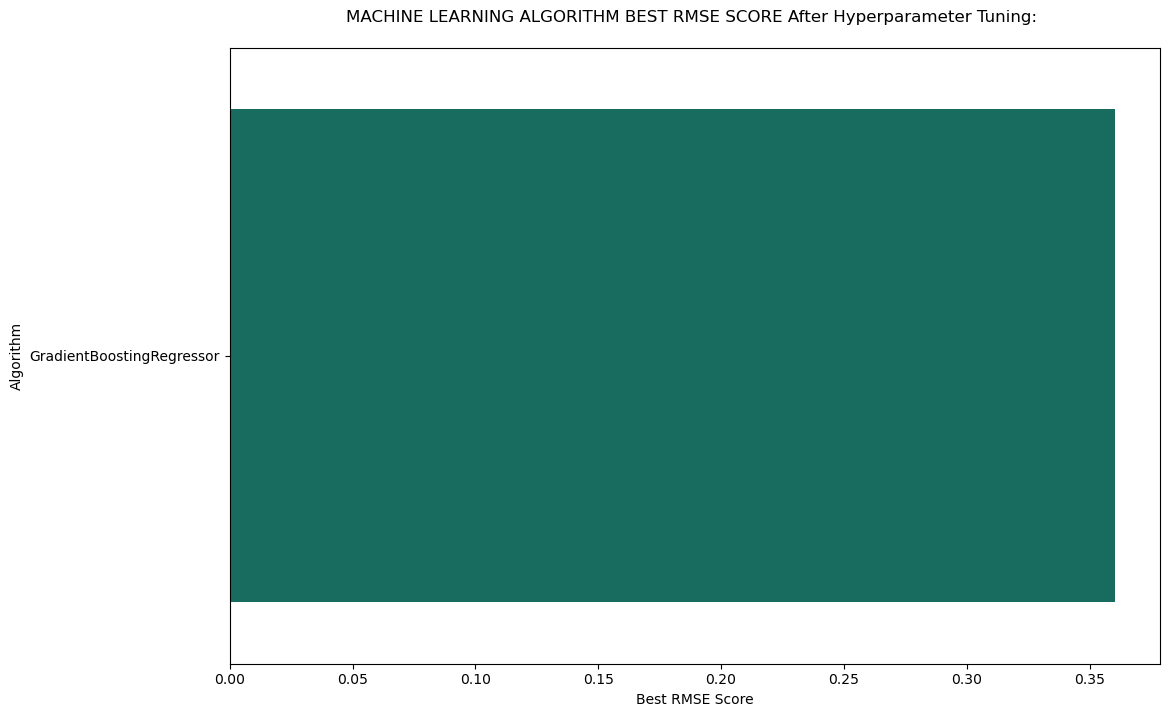

In [200]:
# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Best Score', y='Model', data=results_df, color="#097969")

plt.title('MACHINE LEARNING ALGORITHM BEST RMSE SCORE After Hyperparameter Tuning: \n')
plt.xlabel('Best RMSE Score')
plt.ylabel('Algorithm')
plt.show()